In [329]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

import multiprocessing
from functools import partial
import shutil
import itertools
import collections

In [330]:
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt

In [331]:
def AUC(pred,target): return roc_auc_score(target,pred[:,1])

## Bulk resizing of images

In [332]:
# This function loads a file, resize it and write in the output folder
def img_resize(fname, outdir, sz, in_dir):
    '''
    fname: image filename
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    '''
    os.makedirs(outdir, exist_ok=True)
    im = cv2.imread(in_dir + fname)
    small_im = cv2.resize(im, (sz, sz))
    cv2.imwrite(outdir + fname, small_im)


def parallel_runs(data_list, outdir, in_dir, sz=300, process=4):
    '''
    data_list: list of filenames of images stores in a list
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    process: num of threads in your cpu
    '''
    pool = multiprocessing.Pool(processes=process)
    img_resize_x = partial(img_resize, outdir=outdir, sz=sz, in_dir=in_dir)
    pool.map(img_resize_x, data_list)

def bulk_copyfiles(filelist, source, destination, overwrite = True):
    '''
    filelist: list of filenames you need to copy
    source: source directory
    destination: destination directory
    '''
    if os.path.exists(destination) and overwrite: shutil.rmtree(destination)
    os.makedirs(destination, exist_ok=True)
    for fname in filelist:
        if os.path.exists(source + fname):
            shutil.copy(os.path.join(source, fname), destination)

In [333]:
inputdir = 'data/images/'

filelist = !ls {inputdir}

outdir = 'data/nih_resized/'

# parallel_runs(filelist,outdir,inputdir,300,12) 

## Looking at the labels

In [334]:
pd.options.display.max_rows = 999

labels = pd.read_csv('data/Data_Entry_2017.csv')

labels.head()

,img_id,labels,follow_up,patient_id,age,gender,view,width,height,pix_spacing_x,pix_spacing_y,labels_split,labels_cnt
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,['Cardiomegaly'],1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,"['Cardiomegaly', 'Emphysema']",2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,"['Cardiomegaly', 'Effusion']",2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,['No Finding'],1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,['Hernia'],1


In [335]:
# List of pathologies: 14 and their occurrences in these X-rays

pathology = {'Atelectasis': 11559,  'Cardiomegaly': 2776,  'Consolidation': 4667,  'Edema': 2303,  'Effusion': 13317,  'Emphysema': 2516,  'Fibrosis': 1686,  'Hernia': 227,  'Infiltration': 19894,  'Mass': 5782,  'Nodule': 6331,  'Pleural_Thickening': 3385,  'Pneumonia': 1431,  'Pneumothorax': 5302}

pathology.keys()

dict_keys(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [336]:
label_cnt = labels.groupby('labels').size().reset_index()

label_cnt.columns

Index(['labels', 0], dtype='object')

In [337]:
label_cnt = label_cnt.assign(labels_split = label_cnt['labels'].apply(lambda x: x.split('|')))

label_cnt = label_cnt.assign(label_count = label_cnt.labels_split.apply(lambda x: len(x)))

label_cnt.head()

,labels,0,labels_split,label_count
0,Atelectasis,4215,[Atelectasis],1
1,Atelectasis|Cardiomegaly,88,"[Atelectasis, Cardiomegaly]",2
2,Atelectasis|Cardiomegaly|Consolidation,10,"[Atelectasis, Cardiomegaly, Consolidation]",3
3,Atelectasis|Cardiomegaly|Consolidation|Edema,1,"[Atelectasis, Cardiomegaly, Consolidation, Edema]",4
4,Atelectasis|Cardiomegaly|Consolidation|Edema|E...,2,"[Atelectasis, Cardiomegaly, Consolidation, Ede...",6


In [338]:
label_cnt.loc[label_cnt.label_count == 1].sort_values(by = 0, ascending= False)

pathology_list = list(pathology.keys())

pathology_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [339]:
labels.shape

(112120, 13)

In [340]:
# Finding pair-wise co-occurrence of pathologies

co_occur_dict = collections.defaultdict()
for i in itertools.combinations(pathology_list,2): 
    co_occur_dict[i] = labels['labels'].apply(lambda x: 1 if i[0] in x and i[1] in x else 0).sum()  

for i in sorted(co_occur_dict,key=lambda x: co_occur_dict[x], reverse=True): print(i,co_occur_dict[i])

labels = labels.assign(labels_split = labels['labels'].apply(lambda x: x.split('|')))

labels = labels.assign(labels_cnt = labels['labels_split'].apply(lambda x: len(x)))

# labels.to_csv('data/Data_Entry_2017.csv',index = False)

('Effusion', 'Infiltration') 4000
('Atelectasis', 'Effusion') 3275
('Atelectasis', 'Infiltration') 3264
('Infiltration', 'Nodule') 1546
('Consolidation', 'Effusion') 1287
('Effusion', 'Mass') 1254
('Atelectasis', 'Consolidation') 1223
('Consolidation', 'Infiltration') 1221
('Infiltration', 'Mass') 1159
('Cardiomegaly', 'Effusion') 1063
('Effusion', 'Pneumothorax') 996
('Edema', 'Infiltration') 981
('Infiltration', 'Pneumothorax') 946
('Effusion', 'Nodule') 912
('Mass', 'Nodule') 906
('Effusion', 'Pleural_Thickening') 849
('Atelectasis', 'Pneumothorax') 774
('Infiltration', 'Pleural_Thickening') 750
('Emphysema', 'Pneumothorax') 747
('Atelectasis', 'Mass') 739
('Consolidation', 'Mass') 610
('Infiltration', 'Pneumonia') 605
('Edema', 'Effusion') 593
('Atelectasis', 'Nodule') 590
('Cardiomegaly', 'Infiltration') 587
('Atelectasis', 'Pleural_Thickening') 496
('Mass', 'Pleural_Thickening') 452
('Emphysema', 'Infiltration') 449
('Mass', 'Pneumothorax') 431
('Consolidation', 'Nodule') 428
('A

In [341]:
#Analyzing the labels

labels.groupby('patient_id')['follow_up'].count().sort_values(ascending = False).head()

patient_id
10007    184
13670    173
15530    158
12834    157
13993    143
Name: follow_up, dtype: int64

we can see that some patients have a large number of follow-ups

In [342]:
labels.loc[labels.patient_id == 10007]

,img_id,labels,follow_up,patient_id,age,gender,view,width,height,pix_spacing_x,pix_spacing_y,labels_split,labels_cnt
38081,00010007_000.png,No Finding,0,10007,57,M,PA,2992,2991,0.143,0.143,[No Finding],1
38082,00010007_001.png,No Finding,1,10007,58,M,AP,2500,2048,0.168,0.168,[No Finding],1
38083,00010007_002.png,Infiltration,2,10007,58,M,AP,2500,2048,0.168,0.168,[Infiltration],1
38084,00010007_003.png,Edema,3,10007,58,M,AP,2500,2048,0.168,0.168,[Edema],1
38085,00010007_004.png,Edema|Effusion|Infiltration,4,10007,58,M,AP,2500,2048,0.168,0.168,"[Edema, Effusion, Infiltration]",3
38086,00010007_005.png,Pleural_Thickening,5,10007,58,M,AP,2500,2048,0.168,0.168,[Pleural_Thickening],1
38087,00010007_006.png,Effusion,6,10007,58,M,AP,2500,2048,0.168,0.168,[Effusion],1
38088,00010007_007.png,Effusion,7,10007,58,M,AP,2500,2048,0.168,0.168,[Effusion],1
38089,00010007_008.png,Edema|Infiltration,8,10007,58,M,AP,2500,2048,0.168,0.168,"[Edema, Infiltration]",2
38090,00010007_009.png,No Finding,9,10007,58,M,AP,2500,2048,0.168,0.168,[No Finding],1


## Data preparation for paired experiment

In [343]:
#filtering labels with one single pathology

labels_one = labels.loc[labels.labels_cnt==1] #labels with one pathology

labels_one.shape

(91324, 13)

In [344]:
labels_one.patient_id.nunique()

29564

In [345]:
pathology_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [346]:
labels_one.groupby('labels').size().sort_values(ascending = False)

labels
No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
dtype: int64

In [347]:
# In our study we won't focus on pathologies which are rare i.e Fibrosis, Edema, Pneumonia and Hernia

pairs = ['Atelectasis','Pleural_Thickening']
# 'Atelectasis
# 'Mass'
#  'Cardiomegaly',
#  'Consolidation',
#  'Effusion',
#  'Emphysema',
#  'Infiltration',
#  'Mass',
#  'Nodule',
#  'Pleural_Thickening',
#  'Pneumothorax'

In [348]:
# dropping images with very rare disease

labels_pairs = labels_one.loc[labels_one['labels'].isin(pairs)]

labels_pairs.groupby('labels').size()

labels
Atelectasis           4215
Pleural_Thickening    1126
dtype: int64

In [349]:
# copying these files to another directory

filelist = list(labels_pairs.img_id) #storing filename for X-rays containing the 2 pathologies

len(filelist)

5341

In [350]:
filelist[0]

'00000011_006.png'

In [ ]:
bulk_copyfiles(filelist,'data/nih_resized/','data/exp1/imgs/',overwrite=True) # copying the images from the source folder to experiment folder

In [ ]:
exp_label = labels_pairs[['img_id','labels']]

In [ ]:
exp_label.head()

In [ ]:
exp_label.shape

In [ ]:
# use this is one of the label has no finding
# exp1_label['labels'] = exp1_label['labels'].apply(lambda x: "No_Finding" if x == "No Finding" else x)

exp_label.to_csv('data/exp1/exp_labels.csv',index = False) #saving the labels for the experiment

## Model for paired experiment

In [71]:
!rm -r data/exp1/tmp/

In [275]:
path = 'data/exp1/' #path to the experiment folder

arch = resnet34

sz = 224

bs = 64

metric = [AUC,accuracy]

In [276]:
label_csv = f'{path}exp_labels.csv'

In [277]:
labels = pd.read_csv(label_csv)

In [278]:
labels.head()

,img_id,labels
0,00000011_006.png,Atelectasis
1,00000013_003.png,Pleural_Thickening
2,00000013_009.png,Pleural_Thickening
3,00000020_000.png,Pleural_Thickening
4,00000028_000.png,Pleural_Thickening


In [279]:
labels['labels'].unique()

array(['Atelectasis', 'Pleural_Thickening'], dtype=object)

In [280]:
n = len(list(open(label_csv)))-1 #counting the number of images in the experimental dataset

In [281]:
n

5341

In [282]:
labels.groupby('labels').size()

labels
Atelectasis           4215
Pleural_Thickening    1126
dtype: int64

In [283]:
val_idxs = get_cv_idxs(n) #generating validation indexs

In [284]:
labels.loc[val_idxs].groupby('labels').size() #ratio of the pathologies are maintained

labels
Atelectasis           853
Pleural_Thickening    215
dtype: int64

In [285]:
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_basic,max_zoom=1.1) #defining transforms

In [286]:
data = ImageClassifierData.from_csv(path,'imgs',label_csv,val_idxs=val_idxs,tfms=tfms,bs=bs)

In [287]:
fn = path+data.trn_ds.fnames[0];fn

'data/exp1/imgs/00000011_006.png'

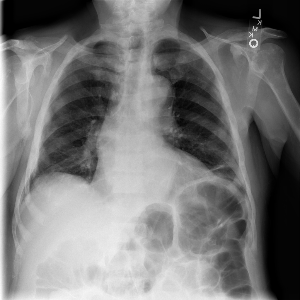

In [288]:
img = PIL.Image.open(fn);img

In [289]:
img.size

(300, 300)

In [290]:
learn = ConvLearner.pretrained(arch,data,precompute=True,metrics = metric)

In [291]:
lrf = learn.lr_find()

 76%|███████▌  | 51/67 [00:00<00:00, 60.95it/s, loss=5.11] 


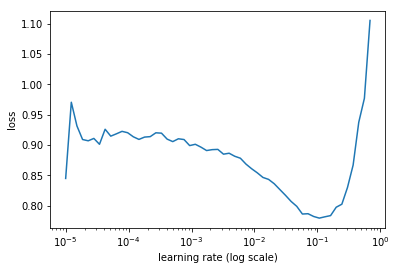

In [292]:
learn.sched.plot(0)

In [293]:
learn.fit(2e-2,1)

epoch      trn_loss   val_loss   AUC        accuracy       
    0      0.569249   0.475137   0.692025   0.796123  



[0.47513677092159495, 0.6920250651016386, 0.7961229962461135]

In [294]:
learn.precompute = False

In [295]:
lrf = learn.lr_find()

 88%|████████▊ | 59/67 [00:09<00:01,  6.14it/s, loss=2.13] 


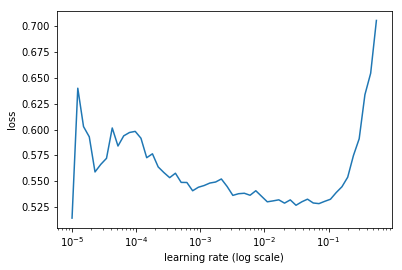

In [296]:
learn.sched.plot(0)

In [297]:
learn.fit(0.5e-2,3,cycle_len=1)

epoch      trn_loss   val_loss   AUC        accuracy       
    0      0.488898   0.454178   0.726875   0.797878  
    1      0.479833   0.441855   0.740492   0.807904       
    2      0.47348    0.443116   0.737879   0.805231       



[0.44311625116011677, 0.7378786879721698, 0.8052306140170378]

In [298]:
lrf = learn.lr_find()

 88%|████████▊ | 59/67 [00:09<00:01,  6.18it/s, loss=2.03] 


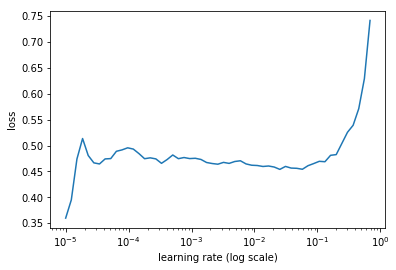

In [299]:
learn.sched.plot(0)

In [300]:
learn.fit(0.5e-2,3,cycle_len=1)

epoch      trn_loss   val_loss   AUC        accuracy       
    0      0.466629   0.441189   0.743315   0.803392  
    1      0.462918   0.439028   0.748897   0.809408       
    2      0.466927   0.437639   0.755793   0.809325       



[0.43763894894543814, 0.7557933045467927, 0.8093248675851261]

In [301]:
learn.unfreeze()

In [302]:
lrf = learn.lr_find()

 90%|████████▉ | 60/67 [00:17<00:02,  3.42it/s, loss=2.07] 

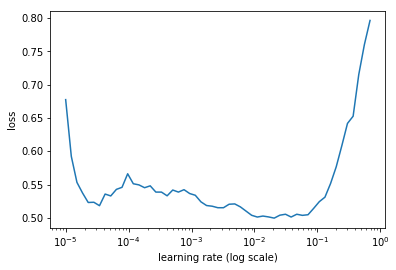

In [303]:
learn.sched.plot(0)

In [304]:
learn.save('exp1_At_vs_Pleural')

In [305]:
learn.load('exp1_At_vs_Pleural')

In [306]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])

In [307]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

 28%|██▊       | 19/67 [00:05<00:15,  3.18it/s, loss=0.524]

Exception in thread Thread-157:
Traceback (most recent call last):
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   AUC        accuracy       
    0      0.484998   0.435891   0.762401   0.810662  
    1      0.455743   0.434111   0.766608   0.810244       
    2      0.413145   0.417649   0.795134   0.803309       
    3      0.402604   0.424275   0.812879   0.80615        
    4      0.363562   0.422976   0.817492   0.805648       
    5      0.298548   0.426898   0.815005   0.815675       
    6      0.252714   0.432332   0.817972   0.817513       



[0.43233182325082664, 0.8179724503144365, 0.8175133677089915]

In [310]:
learn.save('exp1_At_vs_Pleural')

In [311]:
learn.load('exp1_At_vs_Pleural')

In [312]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

 22%|██▏       | 15/67 [00:04<00:16,  3.09it/s, loss=0.249]


Exception in thread Thread-165:
Traceback (most recent call last):
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   AUC        accuracy       
    0      0.258602   0.457172   0.805761   0.829963  
    1      0.265809   0.452068   0.820224   0.8313         
    2      0.202755   0.470794   0.825137   0.819435       
    3      0.231644   0.522544   0.785914   0.805147       
    4      0.196494   0.619585   0.778646   0.818516       
    5      0.132893   0.58999    0.80901    0.824031       
    6      0.094297   0.57755    0.806842   0.821775        



[0.5775502289042753, 0.8068423435321751, 0.8217747316640966]

In [313]:
lrf = learn.lr_find()

 70%|███████   | 47/67 [00:14<00:06,  3.31it/s, loss=0.266] 

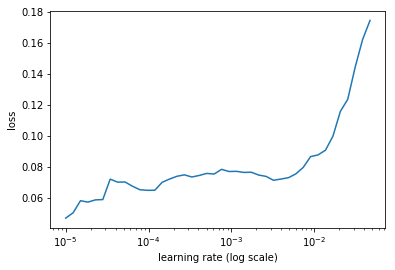

In [314]:
learn.sched.plot(0)

In [315]:
learn.freeze()

In [316]:
learn.save('exp1_At_vs_Pleural')

In [317]:
learn.load('exp1_At_vs_Pleural')

In [318]:
lrf = learn.lr_find()

 84%|████████▎ | 56/67 [00:09<00:01,  5.89it/s, loss=0.0737]

Exception in thread Thread-173:
Traceback (most recent call last):
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/shikhar/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 91%|█████████ | 61/67 [00:10<00:01,  5.83it/s, loss=0.269] 


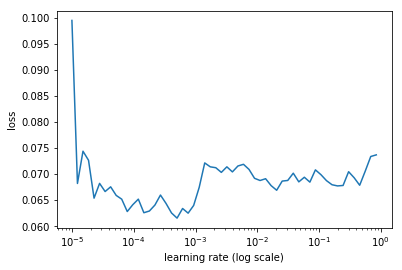

In [319]:
learn.sched.plot(0)

In [320]:
learn.fit(1e-5,3,cycle_len=1)

epoch      trn_loss   val_loss   AUC        accuracy        
    0      0.067764   0.576544   0.807103   0.821775  
    1      0.070547   0.57914    0.808169   0.823613        
    2      0.070571   0.579633   0.807046   0.819936        



[0.5796331798329073, 0.8070455891907746, 0.819936496369979]

In [321]:
log_preds,y = learn.TTA()

In [322]:
probs = np.exp(log_preds)

In [323]:
probs.shape

(5, 1068, 2)

In [324]:
prob_final  = np.mean(probs,axis=0)

In [325]:
prob_final.shape

(1068, 2)

In [326]:
data.classes

['Atelectasis', 'Pleural_Thickening']

In [327]:
AUC(prob_final,y)

0.8307423866517625

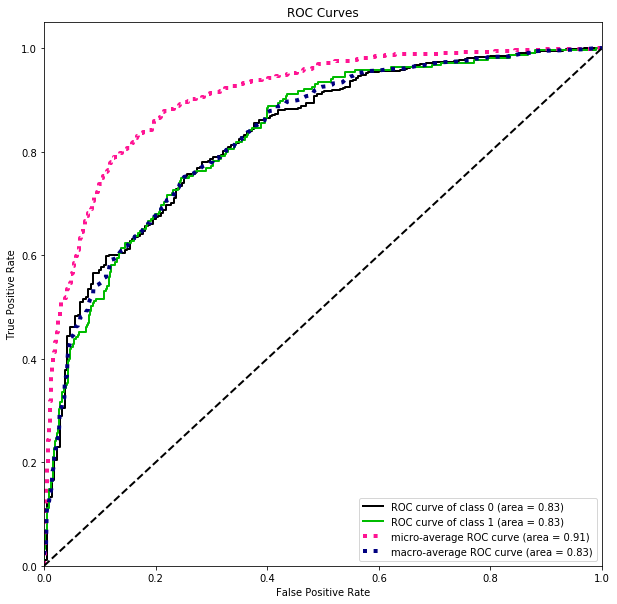

In [328]:
skplt.metrics.plot_roc_curve(y, prob_final,figsize=(10,10))
plt.show()